<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modeling</a></span></li></ul></div>

In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../..')) 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from recidiviz.calculator.modeling.population_projection.super_simulation.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.transition_table import TransitionTable
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy
from recidiviz.calculator.modeling.population_projection.utils.spark_bq_utils import upload_spark_model_inputs
import pandas as pd
from functools import partial

pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 100)

In [5]:
court_data = pd.concat([pd.read_csv(f'../state/VA/VA_jail_data/circuit_criminal_{year}_anon_00.csv') for year in range(2010,2020)])
                      
court_data = court_data.drop(
    ['HearingJury', 'HearingPlea', 'HearingRoom', 'fips', 'Locality', 'DrivingRestrictions', 
     'RestrictionEffectiveDate', 'RestrictionEndDate', 'RestitutionPaid', 
     'RestitutionAmount', 'Military', 'TrafficFatality', 'Sex', 'Race', 'Address', 'Costs', 
     'FinesCostPaid', 'ProgramType', 'CourtDMVSurrender', 'DriverImprovementClinic', 'VAAlcoholSafetyAction', 
     'OffenseDate', 'ConcurrentConsecutive', 'LifeDeath', 'OperatorLicenseSuspensionTime', 'FineAmount', 'ArrestDate',
     'AmendedCharge', 'AmendedCodeSection', 'AmendedChargeType', 'ConcludedBy', 'DispositionDate'], axis=1)
court_data = court_data[court_data.DispositionCode == 'Guilty'].drop('DispositionCode', axis=1)
print(f"number of records: {len(court_data)}")
court_data.head()

court_data = court_data[(court_data.HearingResult == 'Sent') | (court_data.HearingResult == 'Sentenced')]
court_data.SentenceTime = court_data.SentenceTime.fillna(0)
court_data.SentenceSuspended = court_data.SentenceSuspended.fillna(0)
court_data['effective_sentence_months'] = (court_data.SentenceTime - court_data.SentenceSuspended) / 365 * 12
court_data = court_data[court_data.Charge.notnull()]


/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


number of records: 791960


In [6]:
court_data['day'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[2]))
court_data['month'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[1]))
court_data['year'] = court_data.HearingDate.apply(lambda x: int(x.split('-')[0]))

In [7]:
court_data['THEFT'] = court_data.Charge.apply(
    lambda x: any([i in x for i in ['LARCENY', 'BURGLARY', 'ROBBERY', 'SHOPLIFT', 'LARC', 'THEFT', 'THFT']])
)
court_data['DRUG'] = court_data.Charge.apply(
    lambda x: any([i in x for i in [
        'POSS',
        'CONTROLLED SUBSTANCE',
        'SCH 1',
        'DISTRB',
        'DISTRIB',
        'DISTRIBUTION',
        'SELL'
        'PWID', 
        'MARIJUANA',
        'MARIJ',
        'COCAINE',
        'HEROIN',
        'DRUG'
    ]]) and not any([i in x for i in [
        'PORN', 'GUN', 'WEAPON', 'FIREARM', 'CELL PHONE', 'ALCOHOL'
    ]])
)
court_data['DRUG_POSSESSION'] = court_data.Charge.apply(
    lambda x: any([i in x for i in [
        'POSS',
        'PWID', 
    ]])
)
court_data.DRUG_POSSESSION = court_data.DRUG_POSSESSION & court_data.DRUG

court_data['DRUG_SALE'] = court_data.Charge.apply(
    lambda x: any([i in x for i in [
        'DISTRB',
        'DISTRIBUTION',
        'DISTRIB',
        'DIST',
        'PWID', 
        'SALE',
        'SELL'
    ]])
)
court_data.DRUG_SALE = court_data.DRUG_SALE & court_data.DRUG

court_data['DRUG_OTHER'] = court_data.DRUG & ~(court_data.DRUG_SALE | court_data.DRUG_POSSESSION)

court_data['MARIJUANA'] = court_data.Charge.apply(
    lambda x: any([i in x for i in [
        'MARIJUANA',
        'MARIJ',
    ]])
)


# court_data[court_data.DRUG_POSSESSION].groupby(['year', 'month']).count().sort_values(['year', 'month']).Charge.iloc[100:]

In [8]:
def get_most_serious_case(df):
    most_serious_crime = df.sort_values('effective_sentence_months').iloc[-1]
    most_serious_crime['crimes'] = len(df)
    most_serious_crime.DRUG_POSSESSION = df.DRUG_POSSESSION.any()
    most_serious_crime.DRUG_SALE = df.DRUG_SALE.any()
    most_serious_crime.DRUG_OTHER = df.DRUG_OTHER.any()
    most_serious_crime.MARIJUANA = df.MARIJUANA.any()
    return most_serious_crime

court_data = court_data.groupby(['person_id', 'HearingDate'], as_index=False).apply(get_most_serious_case)

In [10]:
drug_data = court_data[court_data.DRUG_POSSESSION | court_data.DRUG_SALE | court_data.DRUG_OTHER]

In [11]:
# Just out of curiousity, let's check out the covariance between the drug crimes. Negative covariance is probably bad
# because it means people only haveone drug crime or another. We want to see large positive covariance between weed
# and other drug crimes
court_data[['DRUG_POSSESSION', 'DRUG_SALE', 'DRUG_OTHER', 'MARIJUANA']].cov()

,DRUG_POSSESSION,DRUG_SALE,DRUG_OTHER,MARIJUANA
DRUG_POSSESSION,0.142787,0.013194,-0.000616,0.026886
DRUG_SALE,0.013194,0.062316,0.000842,0.023592
DRUG_OTHER,-0.000616,0.000842,0.021099,0.002115
MARIJUANA,0.026886,0.023592,0.002115,0.049640


In [12]:
drug_data.MARIJUANA.mean()

0.22626578611980072

In [13]:
#2019 % of drug crimes that were marijuana
366/(366+78+45+43+35+34+29+27+6+5+3+3+3+2)

0.5390279823269514

In [14]:
#according to the internet the precise number is 46%
#2020 % of drgu crimes that were marijuana
250/(250+77+41+34+30+27+27+24+4+3+3+3+2+2+2+2)

0.4708097928436911

# Preprocessing

## TODOs
* can't just drop 0 length sentences
* can't just assume most severe sentence is the marijuana charge
* probation
* fines?
* recidivism
* separate out jail
* total population data


In [15]:
drug_data.head()

,HearingDate,HearingResult,HearingType,Filed,Commencedby,Charge,CodeSection,ChargeType,Class,JailPenitentiary,SentenceTime,SentenceSuspended,ProbationType,ProbationTime,ProbationStarts,AppealedDate,person_id,effective_sentence_months,day,month,year,THEFT,DRUG,DRUG_POSSESSION,DRUG_SALE,DRUG_OTHER,MARIJUANA,crimes
18,2011-03-07,Sent,Trial,2010-09-08,Indictment,POSSESS W/INTENT TO DISTRIBUTE,18.2-248.1,Felony,5,NaN,0.0,0.0,NaN,NaN,NaN,NaN,1000000000614,0.000000,7,3,2011,False,True,True,True,False,False,1
37,2010-09-13,Sent,Trial,2010-06-07,Direct Indictment,DIST MARIJUANA,18.2-248.1,Misdemeanor,1,Jail,365.0,180.0,NaN,NaN,NaN,NaN,1000000001347,6.082192,13,9,2010,False,True,False,True,False,True,3
39,2011-05-13,Sent,Sentencing,2010-12-29,Indictment,DISTRIBUTE MARIJUANA,18.2-248.1,Felony,5,Penitentiary,1460.0,1460.0,Supervised,1460.0,Sentencing,NaN,1000000001514,0.000000,13,5,2011,False,True,False,True,False,True,1
47,2019-06-11,Sentenced,Sentencing,2018-12-19,Indictment,POSS F/A AFTER CONV FELON,18.2-308.2,Felony,NaN,Penitentiary,730.0,0.0,NaN,NaN,NaN,NaN,1000000001680,24.000000,11,6,2019,False,True,True,False,False,False,3
48,2019-11-12,Sentenced,Sentencing,2019-08-19,Direct Indictment,POSSESSION OF HEROIN,18.2-250,Felony,NaN,Penitentiary,1095.0,1060.0,Supervised,545.0,Release,NaN,1000000001680,1.150685,12,11,2019,False,True,True,False,False,False,1


In [16]:
marijuana_data = court_data[court_data.MARIJUANA & court_data.effective_sentence_months > 0.5]
marijuana_data.loc[(~marijuana_data.DRUG_SALE) & marijuana_data.DRUG_POSSESSION, 'DRUG_SALE'] = 'possession'

marijuana_data['time_step'] = (drug_data.year - 2020) * 12 + drug_data.month
outflows_data = marijuana_data.groupby(['time_step', 'DRUG_SALE']).count()[['HearingType']].reset_index().rename(
    {'HearingType': 'total_population', 'DRUG_SALE': 'crime'}, axis=1
)

#2020 fraction
weed_pct_drug_crimes = 0.46
weed_tagged_drug_data = drug_data.MARIJUANA.mean()
outflows_data.total_population *= weed_pct_drug_crimes / weed_tagged_drug_data


outflows_data['compartment'] = 'pretrial'
outflows_data['outflow_to'] = 'prison'
outflows_data.crime = outflows_data.crime.replace({True: 'sale', False: 'other'})
outflows_data = outflows_data[outflows_data['time_step'] < 0]
outflows_data.time_step = outflows_data.time_step.astype(int)
outflows_data.total_population = outflows_data.total_population.astype(float)
outflows_data.head()

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-16-20f4fa220047>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marijuana_data['time_step'] = (drug_data.year - 2020) * 12 + drug_data.month


,time_step,crime,total_population,compartment,outflow_to
0,-119,other,6.099022,pretrial,prison
1,-119,sale,128.079461,pretrial,prison
2,-119,possession,107.749388,pretrial,prison
3,-118,other,16.264059,pretrial,prison
4,-118,sale,60.990220,pretrial,prison


<AxesSubplot:xlabel='time_step'>

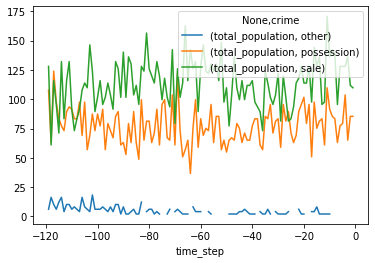

In [19]:
outflows_data.groupby(['crime', 'time_step']).sum().unstack('crime').plot()

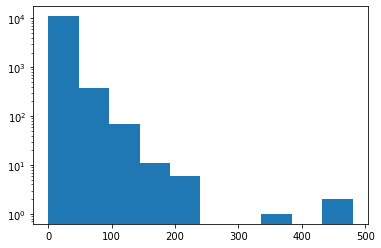

In [20]:
plt.hist(marijuana_data.effective_sentence_months)
plt.yscale('log')

In [21]:
transitions_data = marijuana_data.copy()
transitions_data['compartment_duration'] = transitions_data.effective_sentence_months.round()
transitions_data = transitions_data.groupby(
    ['compartment_duration', 'DRUG_SALE']
).count()[['HearingType']].reset_index().rename({'HearingType': 'total_population', 'DRUG_SALE': 'crime'}, axis=1)
transitions_data['compartment'] = 'prison'
transitions_data['outflow_to'] = 'release'
transitions_data.crime = transitions_data.crime.replace({True: 'sale', False: 'other'})

transitions_data = transitions_data.append(pd.DataFrame({
    'compartment_duration': [24] * 3,
    'total_population': [1] * 3,
    'compartment': ['release'] * 3,
    'outflow_to': ['release'] * 3,
    'crime': ['sale', 'other', 'possession'],
}), ignore_index=True)

transitions_data.total_population = transitions_data.total_population.astype(float)
transitions_data.head()

,compartment_duration,crime,total_population,compartment,outflow_to
0,0.0,other,22.0,prison,release
1,0.0,sale,441.0,prison,release
2,0.0,possession,758.0,prison,release
3,1.0,other,29.0,prison,release
4,1.0,sale,951.0,prison,release


In [22]:
simulation_tag = "cannabis_oct_27"

upload_spark_model_inputs(
    "recidiviz-staging",
    simulation_tag,
    outflows_data,
    transitions_data,
    pd.DataFrame(),
    '../state/VA/2022/VA_2022_cannabis_oct_27_model_inputs.yaml',
)

# Modeling

In [2]:
# Don't worry about any warnings, as long as this doesn't fail you're in business
spark_sim = SuperSimulationFactory.build_super_simulation(
    '../state/VA/2022/VA_2022_cannabis_oct_27_model_inputs.yaml'
)

/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)
/Users/pacopoler/.local/share/virtualenvs/recidiviz-data-Jd9N3JcA/lib/python3.8/site-packages/google/cloud/bigquery/table.py:1852: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  record_batch = self.to_arrow(


outflows_data returned 331 results
transitions_data returned 194 results
total_population_data returned 0 results


initialization time:  16.543426275253296


simulation_time:  14.175240755081177


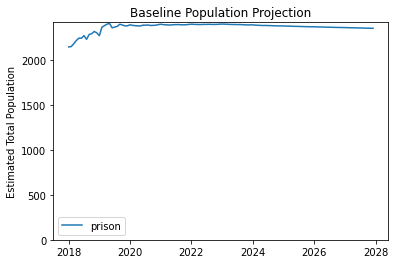

In [3]:
spark_sim.simulate_baseline(['prison'])

[<AxesSubplot:title={'center':'simulation_group: other\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: possession\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>,
 <AxesSubplot:title={'center':'simulation_group: sale\ncompartment: pretrial\noutflow_to: prison'}, xlabel='time_step'>]

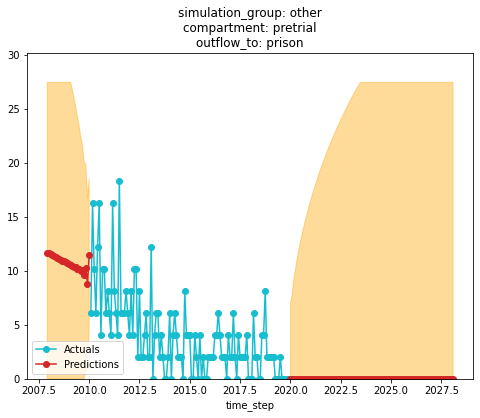

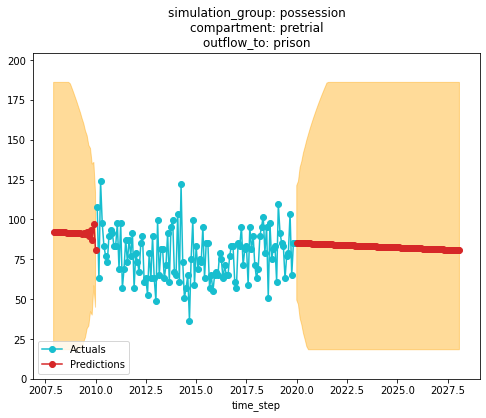

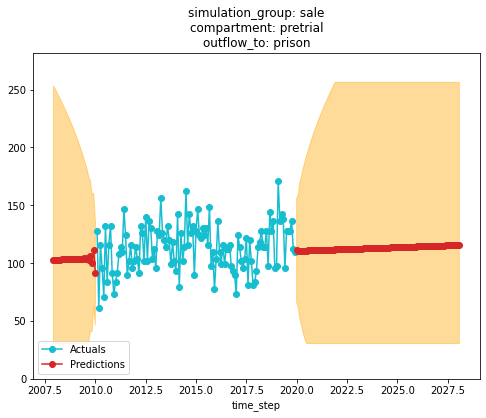

In [25]:
spark_sim.get_arima_output_plots('baseline_middle', by_simulation_group=True)

initialization time:  11.501911163330078
initialization time:  11.286267757415771
simulation_time:  12.895094156265259
simulation_time:  13.650649070739746


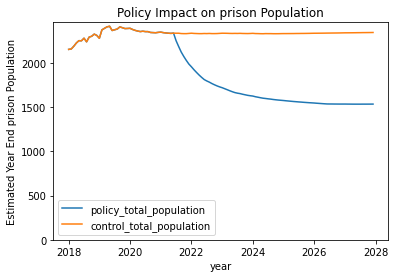

In [26]:
# Legalize drug possession

def legalize_pot():
    return partial(ShellCompartment.reallocate_outflow, 
                   reallocation_fraction=1,
                   outflow='prison',
                   new_outflow=None)

policy_list = [SparkPolicy(policy_fn=legalize_pot(),
                                           spark_compartment='pretrial',
                                           sub_population={'crime': 'possession'},
                                           policy_ts=18,
                                           apply_retroactive=False),
#                SparkPolicy(policy_fn=legalize_pot(),
#                                            spark_compartment='pretrial',
#                                            sub_population={'crime': 'sale'},
#                                            policy_ts=24,
#                                            apply_retroactive=False),
              ]
    
test_results = spark_sim.simulate_policy(policy_list, 'prison')

In [4]:
# maybe don't run this one yourself, no need to spam our output database :)
simulation_tag = 'VA_cannabis_possession_oct_28'
spark_sim.upload_policy_simulation_results_to_bq(simulation_tag)

{'spending_diff':                       prison release
 year                                
 2018.000000              0.0     0.0
 2018.083333              0.0     0.0
 2018.166667              0.0     0.0
 2018.250000              0.0     0.0
 2018.333333              0.0     0.0
 2018.416667              0.0     0.0
 2018.500000              0.0     0.0
 2018.583333              0.0     0.0
 2018.666667              0.0     0.0
 2018.750000              0.0     0.0
 2018.833333              0.0     0.0
 2018.916667              0.0     0.0
 2019.000000              0.0     0.0
 2019.083333              0.0     0.0
 2019.166667              0.0     0.0
 2019.250000              0.0     0.0
 2019.333333              0.0     0.0
 2019.416667              0.0     0.0
 2019.500000              0.0     0.0
 2019.583333              0.0     0.0
 2019.666667              0.0     0.0
 2019.750000              0.0     0.0
 2019.833333              0.0     0.0
 2019.916667              0.0    

In [11]:
test_results

,compartment,year,policy_total_population,simulation_group,control_total_population
year,,,,,
2018.000000,prison,2018.000000,29.265817,other,29.265817
2018.083333,prison,2018.083333,27.138253,other,27.138253
2018.166667,prison,2018.166667,31.450119,other,31.450119
2018.250000,prison,2018.250000,30.977326,other,30.977326
2018.333333,prison,2018.333333,30.788209,other,30.788209
...,...,...,...,...,...
2027.583333,release,2027.583333,25094.273587,sale,25094.273587
2027.666667,release,2027.666667,25209.085195,sale,25209.085195
2027.750000,release,2027.750000,25323.827219,sale,25323.827219
